## ELEC5307-2022-S2: Project 1 report

### Rahul Talla (500551998)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

## Part 0: Prepare for Colab

The default colab uses CPU, you can add GPU resources in Runtime->Change runtime type->dropdown, select GPU->save

**Note: the following code is written for cpu, you need to allocate data and network to GPU on your own if you want to utilize GPU devices.**

## Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [ ]:
"""
#######################################################################################################
# GPU Preparation and memory checking 
# Sourced from and Credited to Jimut Bahan Pal
# Github: https://jimut123.github.io/blogs/ML/ColabTricks.html
#######################################################################################################
"""
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=c7989683d0df6c7031fc43b832dd431d93fbea839890ba63f1f9d02b2d4671f0
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.7 GB  | Proc size: 96.4 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [2]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [3]:
# Downlaoding and preparing initial Train and Test datasets
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=True,
                                        download=True, transform=transform)
trainset = [item for item in trainset]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=False,
                                       download=True, transform=transform)
testset = [item for item in testset]
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/CIFAR10/cifar-10-python.tar.gz to /tmp/CIFAR10
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [4]:
from numpy.lib.index_tricks import index_exp

# Your split codes here.
# You need to random select the 5000 validation images 
# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.


"""
##########################################################
# Part 1.2 - Own work
 - Split Data into Train & Validation
##########################################################
"""

# import required libraries 
import numpy as np
from torch.utils.data import SubsetRandomSampler

valid_size  = 5000
train_size = len(trainset)
n_batch = 4

ind = np.arange(train_size)
np.random.shuffle(ind)
sample_ind = train_size - valid_size
valid_size = len(ind) - sample_ind # Adjust validation set size for subsampling

train_sampler, valid_sampler = SubsetRandomSampler(ind[:sample_ind]), SubsetRandomSampler(ind[sample_ind:])
    
train_loader = torch.utils.data.DataLoader(trainset,batch_size=n_batch,
                                           num_workers=2,sampler=train_sampler
                                          )
valid_loader = torch.utils.data.DataLoader(trainset,batch_size=n_batch,
                                           num_workers=2,sampler=valid_sampler
                                          )

### 1.3 Define a Baseline Convolution Neural Network

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 & 1.5 Define a Loss function and optimizer & Train the network

In [ ]:
import torch.optim as optim

"""
#######################################################
# Part 1.5 - Own work 
- Record Loss and Accuracy 
#######################################################
"""


""" Source : The following accuracy calulator function is inspired 
   from the tutorial codebase provided by ELEC5307 USYD course """
  
def generate_accuracy(net, dataloader):
   
    total_count = 0  # total numbers of test set
    total_correct = 0 # total correct predictions of test set
    for data in dataloader:  # iterate test set/validation set
        inputs = data[0]  # input data, such as images, etc
        targets = data[1]   # ground truth labels
        outputs = net(inputs)    # get the outputs from network
        predicted_labels = outputs.argmax(dim=1)  # obtain the class with highest score as prediction
        comparison = predicted_labels == targets  # get a [True, False,...] matrix. True means correct prediction
        total_count += predicted_labels.size(0)   # accumulate the test number
        total_correct += comparison.sum()      # accumulate the number of correct predictions
        
    return int(total_correct) / int(total_count)


def train_baseline():

  net = Net().train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  
  train_losses = []
  valid_losses = [] 
  train_accs = []
  valid_accs =[]

  print_every = 2000  # print every 2000 mini-batches

  for epoch in range(2):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()

          if i % print_every == (print_every-1):   
            train_loss = running_loss/print_every
            train_losses.append(train_loss)
            running_loss = 0.0


            # Validation loss
            running_valid_loss = 0
            for ind, data in enumerate(valid_loader, 0):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_valid_loss += loss.item()
                
            valid_loss = running_valid_loss / (valid_size/n_batch)
            valid_losses.append(valid_loss)

            train_acc = round(generate_accuracy(net, testloader)*100)
            train_accs.append(train_acc)
            valid_acc = round(generate_accuracy(net, valid_loader)*100)
            valid_accs.append(valid_acc)
            print("Test Accuracy: {}% Validation Accuracy: {}%".format(train_acc,valid_acc))
            print('%d epoch %5d, Current train loss: %.3f Current valid loss: %.3f' %(epoch + 1,i + 1, train_loss,valid_loss))

  return net,train_losses,valid_losses,train_accs,valid_accs

      

net,train_losses,valid_losses,train_accs,valid_accs = train_baseline()

Test Accuracy: 10% Validation Accuracy: 10%
1 epoch  2000, Current train loss: 2.301 Current valid loss: 2.292
Test Accuracy: 24% Validation Accuracy: 24%
1 epoch  4000, Current train loss: 2.164 Current valid loss: 2.035
Test Accuracy: 29% Validation Accuracy: 28%
1 epoch  6000, Current train loss: 1.953 Current valid loss: 1.899
Test Accuracy: 37% Validation Accuracy: 37%
1 epoch  8000, Current train loss: 1.789 Current valid loss: 1.717
Test Accuracy: 41% Validation Accuracy: 40%
1 epoch 10000, Current train loss: 1.690 Current valid loss: 1.661
Test Accuracy: 41% Validation Accuracy: 40%
2 epoch  2000, Current train loss: 1.619 Current valid loss: 1.695
Test Accuracy: 46% Validation Accuracy: 45%
2 epoch  4000, Current train loss: 1.550 Current valid loss: 1.531
Test Accuracy: 44% Validation Accuracy: 43%
2 epoch  6000, Current train loss: 1.523 Current valid loss: 1.556
Test Accuracy: 47% Validation Accuracy: 46%
2 epoch  8000, Current train loss: 1.481 Current valid loss: 1.479
T

### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

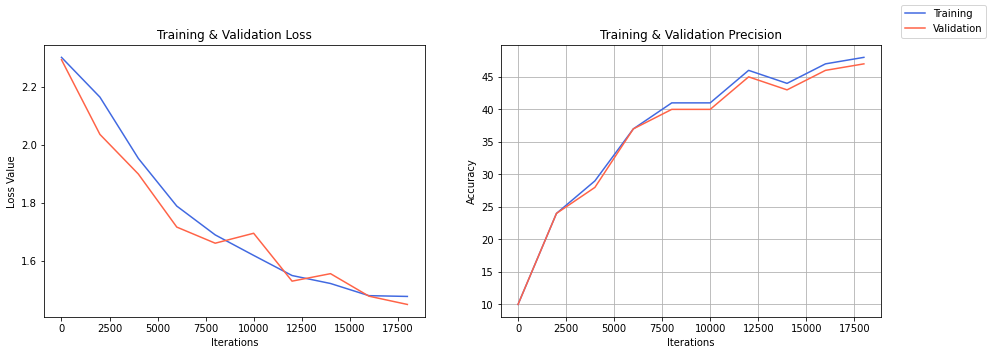

In [ ]:
# Overfitting: trainloss < valid loss

# Underfitting: train loss > valid loss

# Optimal when -> train loss ~ valid loss

"""
#######################################################
# Part 1.6 - Own work 
- Visualise Loss and Accuracy 
#######################################################
"""

import matplotlib.pyplot as plt
import numpy as np
iterations = np.arange(len(train_losses))*2000
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].set_title('Training & Validation Loss')
ax[0].plot(iterations, train_losses, '-', color='royalblue')
ax[0].plot(iterations, valid_losses, '-', color='tomato')
ax[0].set_ylabel('Loss Value')
ax[0].set_xlabel('Iterations')

ax[1].plot(iterations,train_accs, '-', color='royalblue')
ax[1].plot(iterations,valid_accs, '-', color='tomato')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Iterations')
ax[1].set_title('Training & Validation Precision')
plt.grid()

fig.legend( labels=['Training', 'Validation'],
           loc="upper right")
plt.show()



### 1.7 Eval the trained network

In [ ]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

Accuracy of the network on the 10000 test images: 46 %


## Part 2: Hyperparameters Selection

Hyperparameter Search Options:

| Hyperparameter  | Choices |
| --------------  | ------- |
| Epochs          | `[1, 2, 4, 8, 16]`    |
| Learning Rate   | `[0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]`    |
| Batch Size      | `[2, 4, 8]`    |

#### **Question**: What are the choices that could be empirically ignored without doing any experiments? What are the effects of such hyperparameters?

Each of the hyperparameters influence the model’s capacity to learn and therefore evaluate performance. 

An epoch is an event at which all samples in the training dataset have been through the network/model. Generally speaking, such a parameter is significant in its ability to influence model’s performance as it measures the amount of familiarity the classifier has achieved with the training data while minimising errors. Errors such as underfitting and overfitting are main consequences of sub optimal epoch amounts. Among the number of epochs available, we can empirically ignore parameter values such as `[1,2,4]` with consideration of the network design characteristics and the simplicity of the CIFAR-10 dataset. The number of epochs required to achieve optimal performance (divergence) is often dependent on the complexity of the network model and the training dataset. For this reason, we can choose to include epochs of `[8,16]`. 

Similarly, a learning rate is another key hyperparameter in determining the appropriate weights for the network model to use and update during backpropagation. Its choice is also dependent on the complexity and design characteristics of the dataset. Often our aim is to reach the global minimum or in the alternative case a local minimum. However, the process of effectively minimising loss can be mapped to careful selection of the learning rate. Selecting a very small value may lead to larger training periods with slower divergence and only achieving local minimum while a large learning rate may overshoot the global or even local minima which may only result in divergence. In consideration of this understanding, we can empirically ignore the larger `[0.005, 0.001]` and smaller `[0.00005, 0.00001]`.

Batch size is the number of training samples run-through the network/model before weights/model parameters are updated. The batch size used in the network defines the type of gradient descent algorithmic approach taken to find the local/global minimum of the cost function. When a batch comprises of all samples in the training dataset its defined as batch gradient descent. While a batch comprising of only one sample would be stochastic gradient descent. Since the batch values considered are all greater than 1 and less than the size of the training data, we define our approach as mini-batch gradient descent. The choice of batch size requires expertise and refinement, the following paper states “…is typically chosen between 1 and a few hundreds, e.g. batch size = 32 is a good default value” (Yoshua Bengio,2012). Since a value as large as 32 is often recommended a small value such as 2 may be empirically ignored leaving `[4,8]`


### Part 2.1: Experimentation

In [5]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.

"""
#######################################################
# Part 2 - Own work - Subsampling

  We create a function to reduce training time by 
  sampling a portion of the train & valid datasets 
  for the dataloader 
#######################################################
"""

def data_prep(train_fast,split,train_size,valid_size,scale_factor):

  if train_fast:
    ind = np.arange(train_size)
    np.random.shuffle(ind) # shuffle input data
    ind = ind[:int(train_size/scale_factor)]
    sample_ind = int(len(ind)*split) # should be below train dataset size
  else:
    ind = np.arange(train_size)
    np.random.shuffle(ind)
    sample_ind = train_size - valid_size
    valid_size = len(ind) - sample_ind # Adjust validation set size for subsampling

  return [ind,sample_ind]



In [6]:

"""
#######################################################
# Part 2 - Own work - Train Loop

  We create a general function to use in subsequent hyperparameter search loop,
  which takes:
  -  the train_loader -> Generated based on current iteration (i.e. batch = 8 and lr = 0.001)
  - valid_loader -> Generated based on current iteration (i.e. batch = 8 and lr = 0.001)
  - n_batch -> batch_size
  - lr -> learning rate
#######################################################
"""

import torch.optim as optim
def train(train_loader, valid_loader,n_batch,lr):

  net = Net()
  """ 
  ##############
    GPU 
  ##############
  """
  if torch.cuda.is_available():
        net = net.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  
  train_losses = []
  valid_losses = [] 
  train_accs = []
  valid_accs =[]

  for epoch in range(16):  # Run 16 Epochs for all

      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          """ 
          ##############
           GPU 
          ##############
          """
          if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()


          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          """ 
          ##############
           GPU 
          ##############
          """
          if torch.cuda.is_available():
            loss = loss.cpu()

          # print statistics
          running_loss += loss.item()

      print('%d epoch, train_loss: %.3f' %(epoch + 1, running_loss / len(train_loader)))
      train_losses.append(running_loss/ len(train_loader))
      train_running_loss = 0.0
                
      val_running_loss = 0.0
      for i, data in enumerate(valid_loader, 0):
          # get the inputs
          inputs, labels = data
          """ 
          ##############
           GPU 
          ##############
          """
          if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          """ 
          ##############
           GPU 
          ##############
          """
          if torch.cuda.is_available():
            loss = loss.cpu()
          # print statistics
          val_running_loss += loss.item()
      print('%d epoch, val_loss: %.3f' %(epoch + 1, val_running_loss / len(valid_loader)))
      valid_losses.append(val_running_loss / len(valid_loader))
      val_running_loss = 0.0    

      val_correct = 0
      val_total = 0
      with torch.no_grad():
          for data in valid_loader:
              images, labels = data
              """ 
              ##############
              GPU 
              ##############
              """
              if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
              outputs = net(images)
              if torch.cuda.is_available():
                outputs = outputs.cpu()
                labels = labels.cpu()

              _, predicted = torch.max(outputs.data, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()
      print('Accuracy of the network on the 5000 validation images: %d %%' % (
          100 * val_correct / val_total))    
      valid_accs.append(100 * val_correct / val_total)

      test_correct = 0
      test_total = 0
      with torch.no_grad():
          for data in testloader:
              images, labels = data
              """ 
              ##############
              GPU 
              ##############
              """
              if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
              outputs = net(images)
              if torch.cuda.is_available():
                outputs = outputs.cpu()
                labels = labels.cpu()
                
              _, predicted = torch.max(outputs.data, 1)
              test_total += labels.size(0)
              test_correct += (predicted == labels).sum().item()
      print('Accuracy of the network on the 10000 test images: %d %%' % (
          100 * test_correct / test_total))
      train_accs.append(100 * test_correct / test_total)
  print('Finished Training\n')

  return train_losses,valid_losses,train_accs,valid_accs

In [7]:

import itertools

# Options
batch = [2, 4, 8]
lr = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

"""
#######################################################
# Part 2 - Own work - Hyperaparameter Loop (Grid Search)

  We create the hyperparameter search loop that feeds each combination 
  to the train loop by batch size:

  - group_by -> Show output by keeping batch size same 
    (i.e. b= 2 lr = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] then group_by = 6)
#######################################################
"""

split = 0.7
train_size = 50000 # before train-valid split
valid_size = 5000
train_fast = True
scale_factor = 4

ind,sample_ind = data_prep(train_fast,split,train_size,valid_size,scale_factor)
train_sampler, valid_sampler = SubsetRandomSampler(ind[:sample_ind]), SubsetRandomSampler(ind[sample_ind:])

def hyperparam_search(batch,lr,train_sampler,valid_sampler):

  results = {}
  for i in range(len(batch)):
    # Try all lr
    cur_batch = batch[i]
    # Creating train and valid loader for current batch option  
    train_loader = torch.utils.data.DataLoader(trainset,batch_size=cur_batch,
                                              num_workers=2,sampler=train_sampler
                                              )
    valid_loader = torch.utils.data.DataLoader(trainset,batch_size=cur_batch,
                                              num_workers=2,sampler=valid_sampler
                                          )

    for j in range(len(lr)):

      cur_lr = lr[j]
      print("Cur Batch: {} Cur LR {}".format(cur_batch,cur_lr))

      train_losses,valid_losses,train_accs,valid_accs = train(train_loader, valid_loader,cur_batch,cur_lr)
      key = "B"+ str(cur_batch) + "LR" + str(cur_lr) # Add to dictionary with label (batch2 l=0.001 is B2LR0.001)
      results[key] = {"train_losses" : train_losses,"valid_losses":valid_losses,"train_accs": train_accs,"valid_accs": valid_accs}

      
  return results

results = hyperparam_search(batch,lr,train_sampler,valid_sampler)

Cur Batch: 2 Cur LR 0.005
1 epoch, train_loss: 2.270
1 epoch, val_loss: 2.221
Accuracy of the network on the 5000 validation images: 18 %
Accuracy of the network on the 10000 test images: 19 %
2 epoch, train_loss: 2.123
2 epoch, val_loss: 2.117
Accuracy of the network on the 5000 validation images: 18 %
Accuracy of the network on the 10000 test images: 20 %
3 epoch, train_loss: 2.019
3 epoch, val_loss: 2.043
Accuracy of the network on the 5000 validation images: 23 %
Accuracy of the network on the 10000 test images: 22 %
4 epoch, train_loss: 1.979
4 epoch, val_loss: 2.006
Accuracy of the network on the 5000 validation images: 26 %
Accuracy of the network on the 10000 test images: 26 %
5 epoch, train_loss: 2.097
5 epoch, val_loss: 2.163
Accuracy of the network on the 5000 validation images: 15 %
Accuracy of the network on the 10000 test images: 15 %
6 epoch, train_loss: 2.071
6 epoch, val_loss: 2.081
Accuracy of the network on the 5000 validation images: 24 %
Accuracy of the network on 

In [8]:
# Mount Gdrive for uploading/downloading results
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [9]:
# Saving and Uploading Results
import pickle
# pickle.dump(results, open("/content/gdrive/My Drive/Colab Notebooks/ELEC5307/assignment1/resALLFastTrainGPU2.pickle","wb"))

newres = pickle.load(open("/content/gdrive/My Drive/Colab Notebooks/ELEC5307/assignment1/resALLFastTrainGPU2.pickle","rb"))
len(newres)

18

In [16]:

"""
#######################################################
# Part 2 - Own work - Plotting Function (Interactive Plot)

  Takes the batch size of interest i.e. "B2","B4","B8"
  to return a loss and accuracy plots
  of all combinations of learning rates
#######################################################
"""
# Function to Print Desired Graphs
import matplotlib.pyplot as plt
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
cols = plotly.colors.DEFAULT_PLOTLY_COLORS

def plot(results,batch):

    filteredDict = {k:v for k,v in results.items() if k.startswith(batch)}
    
    fig = make_subplots(rows=2, cols=6, shared_xaxes=True,vertical_spacing=0.02,
                        subplot_titles=("0.005", "0.001", "0.0005", "0.0001", "0.00005", "0.00001"))
    
    i = 1
    legend = False
    for key in filteredDict:  
        
        if i==6:
          legend = True

        trace = go.Scatter(x=np.arange(len(filteredDict[key]['train_losses'])), y=filteredDict[key]['train_losses'],
                           legendgroup='group1',showlegend=legend,
                           name = "train loss", line=dict(width=2, color=cols[0]))
        
        fig.append_trace(trace,1,i)
        
        trace = go.Scatter(x=np.arange(len(filteredDict[key]['valid_losses'])), y=filteredDict[key]['valid_losses'],
                           legendgroup='group1',showlegend=legend,
                           name = "valid loss",line=dict(width=2, color=cols[1]))
        
        fig.append_trace(trace,1,i)

        trace = go.Scatter(x=np.arange(len(filteredDict[key]['valid_accs'])), y=filteredDict[key]['valid_accs'],
                           legendgroup='group2',showlegend=legend,
                           name = "valid accuracy",line=dict(width=2, color=cols[2]))

        fig.append_trace(trace,2,i)
        
        
        trace = go.Scatter(x=np.arange(len(filteredDict[key]['train_accs'])), y=filteredDict[key]['train_accs'],
                           legendgroup='group2',showlegend=legend,
                           name = "train accuracy",line=dict(width=2, color=cols[3]))
        
        fig.append_trace(trace,2,i)

        i+=1
      
    plot_title = "Batch " + str(batch)[1]
    fig.update_layout(template="plotly_white", height=400, width=1400, title_text=plot_title,margin=dict(l=5,r=5,b=5,t=50))
    
    fig['layout']['yaxis']['title']='Loss'
    fig['layout']['yaxis7']['title']='Accuracy'
    print(fig.show())
 

In [103]:

"""
#######################################################
# Part 2 - Own work - Plotting Function (Static Plot)

  Takes the batch size of interest i.e. "B2","B4","B8"
  to return a loss and accuracy plots
  of all combinations of learning rates
#######################################################
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['axes.grid'] = True

def plot(results,batch):

    filteredDict = {k:v for k,v in results.items() if k.startswith(batch)}
    fig, ax = plt.subplots(nrows=2, ncols=6,figsize=(30,10), sharex=True)
    
    cols = ["0.005", "0.001", "0.0005", "0.0001", "0.00005", "0.00001"]
    rows = ['Loss','Accuracy']

    for axes, col in zip(ax[0], cols):
      axes.set_title(col)
    for axes, row in zip(ax[:,0], rows):
      axes.set_ylabel(row, rotation=90, fontsize=15)
    
    i = 0

    for key in filteredDict:  
       
        ax[0,i].plot(np.arange(len(filteredDict[key]['train_losses'])), filteredDict[key]['train_losses'], color = 'royalblue', marker = 'o')
        ax[0,i].plot(np.arange(len(filteredDict[key]['valid_losses'])), filteredDict[key]['valid_losses'], color = 'tomato', marker = 'o')
        ax[0,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax[1,i].plot(np.arange(len(filteredDict[key]['valid_accs'])), filteredDict[key]['valid_accs'], color = 'r', marker = 'o')
        ax[1,i].plot(np.arange(len(filteredDict[key]['train_accs'])), filteredDict[key]['train_accs'], color = 'g', marker = 'o')
        ax[1,i].set_yticks(np.arange(0, 60, 10)) # To make it easier to see differences
        ax[1,i].set_xticks(np.arange(0, 16, 2))
        ax[1,i].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        if i not in range(0,5):
          ax[0,i].legend(['train_loss', 'val_loss'], loc='center left', bbox_to_anchor=(1, 0.5))
          ax[1,i].legend(['val_accuracy', 'test_accuracy'], loc='center left', bbox_to_anchor=(1, 0.5))
        
        i+=1

    plt.suptitle("Batch " + str(batch)[1], fontsize=25)  
    plt.show()

2


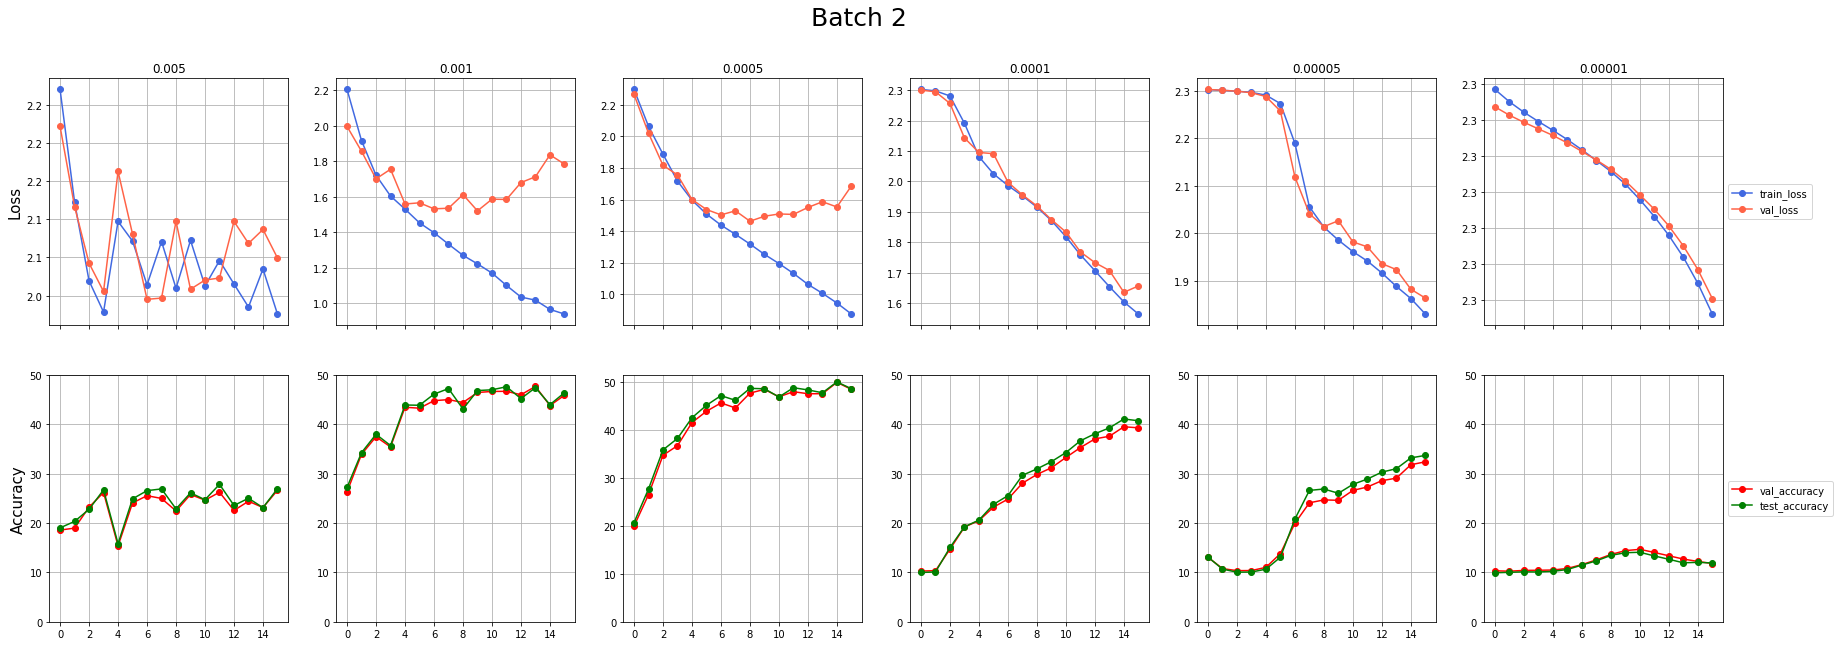

In [104]:
plot(newres,"B2")

2


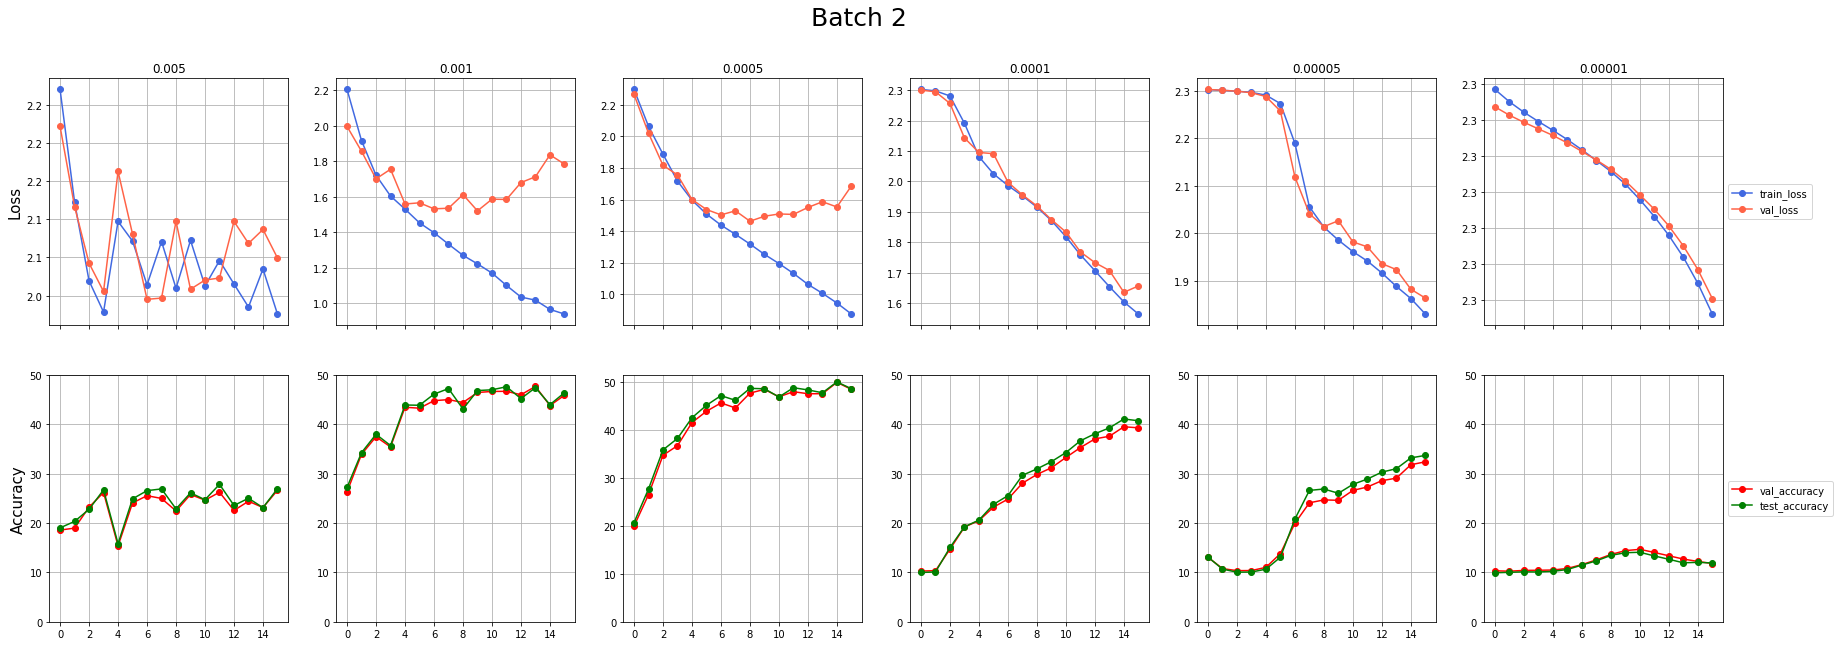

In [105]:
plot(newres,"B2")

2


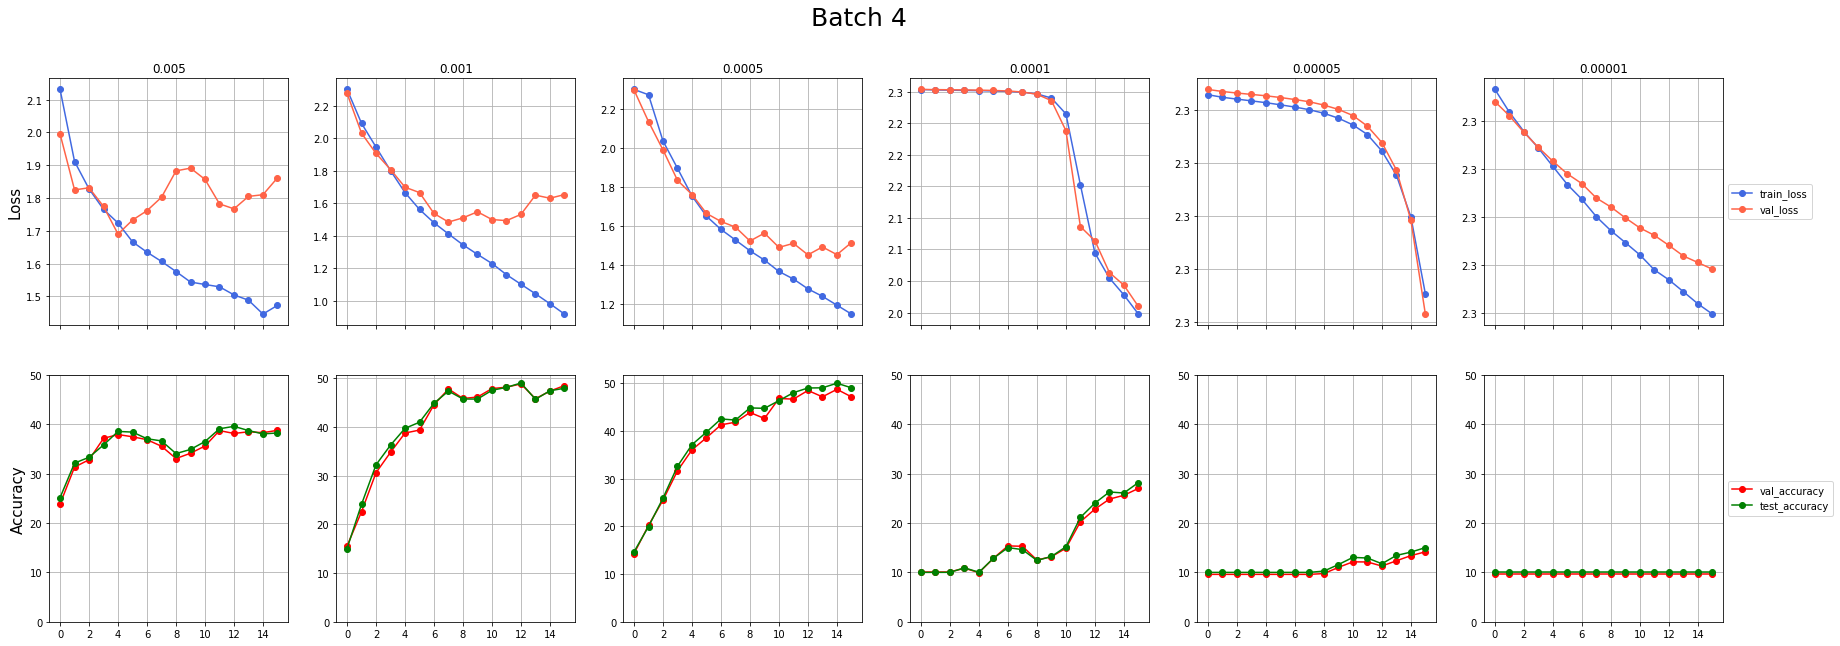

In [108]:
plot(newres,"B4")

2


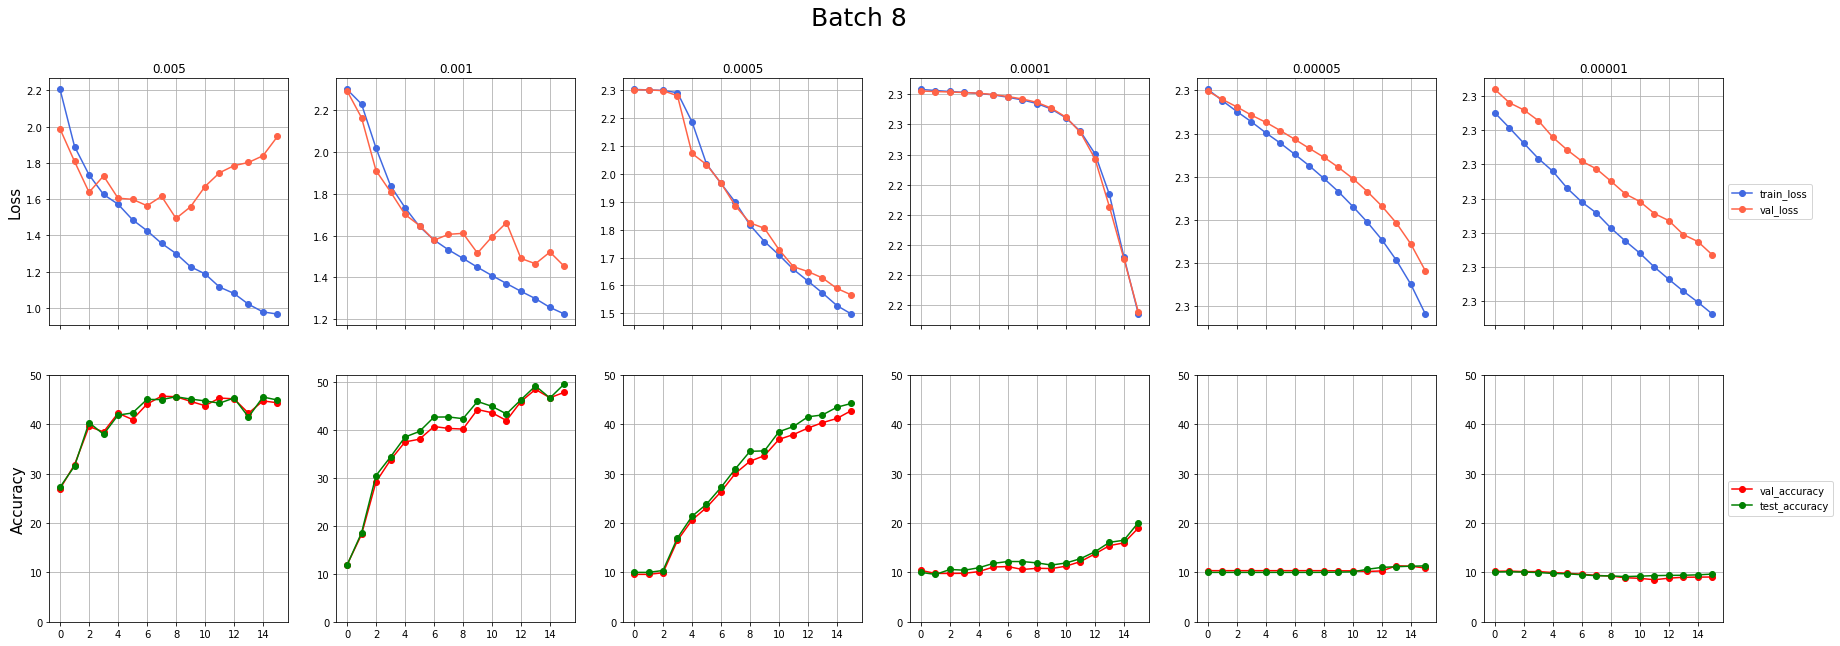

In [109]:
plot(newres,"B8")

### Part 2.2 - Analysis

#### **Question**: Were you correct after you conduct the experiments?

For the experiments carried however, we consider all combinations of parameters to test the previous inferences made empirically. We can observe that within the epoch range of 1-4, the general loss values are relatively high in comparison to those found after larger epoch periods. We can also observe that accuracy achieved on both validation and training datasets also follow similar patterns, therefore our previous inferences on the epoch choices were appropriate. For learning rates, we observe that the extremities of the range provided i.e. `[0.005, 0.00001]` present evidence of suboptimal accuracies with signs of model instability. With majority of these converging at earlier epochs with relatively low accuracies. For the batch sizes however, we observe that while the influence of epoch and learning rates is evident, overall effect of various batch sizes is difficult to determine as values provided are relatively small in comparison to the training dataset. 

#### **Question**: How many epochs are passed when the network is converged?

The graphs above, represent the model performance across various batch sizes and learning rates while controlling the batch value at each experiment. For the epoch however we visualise the network performance across the entire range of 16 epochs, as this would cover all cases without affecting the validity of the experiments. Generally, however we can observe convergence across the various batch sizes and excluding those with no noticeable linearity/pattern (i.e., combinations of Batch =`[2,4]` LR = `[0.005,0.00001]` ). Such convergence is mostly evident around epochs of 5-8 before some form of overfitting occurs. However, in some cases we can observe convergence at epochs of around 10 and even 16 (i.e., combinations of Batch = `[4,8]` LR = `[0.0005]`)

#### **Question**: Why too large or too small learning rates are not good choices?

Learning rate (λ) defines the speed at which we approach optimal weights for the network/model with respect to the loss gradient descent. In choosing both extremities of large and small LR can lead to wastage of training time, resources and economical implications depending on the platform infrastructure (i.e., cloud). As mentioned earlier small learning rates may take too long to approach minima and can mistake a local minimum for a global one. While large learning rates may overshoot the global or even local minima which may only result in divergence. It is preferred to select one that is efficient in terms of time and resources while effective in terms of model performance and stability. The graphic below is good example on the effects of learning rates and the signs of under/overfitting.


![LR effects](https://raw.githubusercontent.com/Rahultalla29/az/master/overfitting%20and%20underfiiting%20%20and%20lr%20effects.PNG)


#### **Question**: What is the specification of the computer you are using? E.g., the CPU/GPU type and the corresponding memory?

All training and experiments entirely ran on Google Collab, with GPU accelerator.
•	GPU: 12GB NVIDIA Tesla K80 GPU

1.   GPU: 12GB NVIDIA Tesla K80 GPU
2.   Gen RAM Free: 12.8 GB 
3.   CUDA: cu80
4.   GPU RAM Free: 15109MB

#### **Question**: How long do you run an epoch? Did you use samples of the original dataset to speed up your progress, and how did it work?

Partial training was initially done in the local runtime using Google Collab’s CPU with each epoch taking approximately 50-70 seconds. However, after estimating the time it would take for running all combinations of the hyperparameter options, code was improved to use Google Collab’s GPU. 
This would involve identifying the availability of CUDA and then allocating resources during the training to the GPU and then assigning it to CPU again for calculation of accuracies/loss etc.

While this improves the training time, I’ve also created a function named data_prep() which takes a Boolean value (train_fast) indicating whether scaling of the dataset should be conducted in order to reduce training time. A float value (split) indicating the split ratio for the training and validation datasets. The size of the original training dataset and the desired validation data size is also taken, these would be utilised in the case when train_fast is False in which case the usual 45000:5000 spilt would be applied. If the train_fast value is True a corresponding scale factor is also required. For the experimentation conducted a scale factor of 4 was used. 

When the train_fast value is True and a valid scale factor is provided, the original training dataset of size 50000 is used to create an array of random indices corresponding to the samples of the train dataset. Next the indices of these samples are then scaled down (in terms of the no. of image samples). The resulting indices are divided on the given split ratio (i.e., 0.7) where training dataset gets 70% and validation gets 30%. During the training process, accuracies would be calculated on these split datasets and the untouched test dataset. This function provides the indices which can then be used to randomly sample using the SubsetRandomSampler() function for subsequent dataloaders.

#### **Question**: Are there any overfitting problems?

We do observe overfitting problems especially with the lower learning rates which is indicative of their nature. This can be observed at the event at which the following cases occur:
Overfitting -> train loss < valid loss and valid acc< train acc

*   Overfitting -> train loss < valid loss and valid acc< train acc
*   Underfitting->train loss > valid loss and valid acc> train acc
*   Optimal ->train loss ~ valid loss and train acc ~ valid acc



### **Question**: What was the combination of hyperparameters you chose and why?
-----

Note: No need to test all epochs only 16 as it covers the 1,2,4,8.

When considering the various visualisations, we are required to consider two main motivations

*	  Best loss:accuracy ratio
*	  Best time taken to achieve the above (epochs)
* 	Stability

First looking at the loss to accuracy ratio of the different combinations we can quickly rule out several obvious sub-optimal hyperparameters. The following is the list of combinations and the reason for their exclusion:

All combinations of batch size `[2,4,8]`, LR `[0.005,0.00001]` and Epoch `[1 to 16]`

* 	As the previous inferences made on the parameters for empirical exclusion, learning rates `[0.005,0.00001]` are the extremities of the given options. With one being too large and other being too small for any useful performance. We can observe the instability and lack of clear exponential growth pattern of test and validation accuracies. We can also observe similar incompetency with the loss values. 
* 	In fact, these observations are evident across the 16-epoch period with no sign of stability across any 2-3 epoch interval. Due the nature of the learning rate values the incompatibility of the hyperparameters can be found across the batch sizes `[2,4,8]` where a learning rate of 0.00001 leads to overfitting and lower values lead to inconsistent loss/accuracy values.

All combinations of batch size `[2,4,8]`, LR `[0.00005,0.001]`, Epoch `[1 to 16]`

* 	Coincidently, the learning rates `[0.00005,0.001]` are the second smallest and largest of the options. We can observe for all batch sizes that a LR of 0.0005 provides relatively stable loss and accuracy curves across the 16-epoch range. However, when we consider the overall accuracy, the time taken to converge and loss of each model, they underperform in comparison to some of the other combinations. 
* 	For learning rate of 0.001 however we do observe much better accuracies however by the 6-8 epoch intervals we observe overfitting as the train loss < valid loss. While this can mean to limit the training at epoch 8, looking at the accuracies and steepness of the curves we observe better options are available.

Finally we are left with learning rates `[0.0005, 0.0001]`, among all batch sizes and epoch ranges the two learning rates are compared with the loss achieved at each epoch limit (i.e. 4,8,16) and then the accuracy observed (loss: accuracy). We finally rank these by the stability of the curves as they approach the specific epoch. This approach of elimination results in best two combinations
`[Batch 4 – 16 epoch – LR 0.0001]`. When considering overall accuracy to loss ratio and stability in model this option seems to be the optimal choice. Where there appears a clear convergence by the 16poch with negligible overfitting. 
`[Batch8 – 8 epoch – LR 0.0005]`. For this option we observe better convergence with minimal overfitting and in comparisons with the other option we achieve a much higher accuracy with lower number of epochs.

Therefore, for option 2 we can see that all motivations of the hyperparameter search have been satisfied to some extent. We have observed relativity optimal loss:accuracy ratio, minimal epoch period taken to achieve reasonable accuracy and stability in curve.

Choices for hyperparameters are:

| Hyperparameter  | Choice |
| --------------  | ------- |
| Epochs          | `8`    |
| Learning Rate   | `0.0005`    |
| Batch Size      | `8`    |

### Part 3: More options

Please indicate the **three** tasks you are assigned here:

1) Transformation: e.g. Resize (hyperparameters: size, interpolation), ...

2) Structure: 

3) Training procedure: 

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1) 

2) 


_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) 

2) 


_____

### Reference
1. Author, Title, url
2. 
3. 

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your pytorch software versions.